In [3]:
import subprocess
import spot
from spot.jupyter import display_inline

from IPython.display import display

spot.setup()

Concepts (FLAGS and Automaton) :
https://spot.lre.epita.fr/concepts.html

spot.formula("Fb & (Fb -> FXa)")

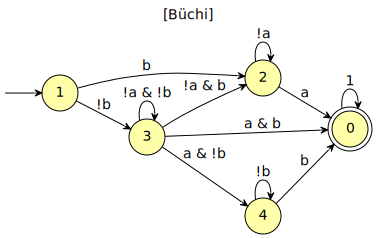

In [4]:
f = spot.formula("F(b) & ( (F b) -> (F(X a)) )")
display(f)
a = spot.translate(f, 'det', 'sbacc')
a

spot.formula("Fb & G!(a & b) & (Fb U Fa)")

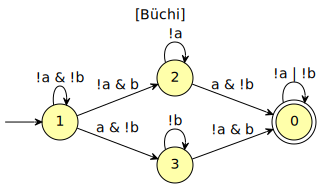

In [5]:
f = spot.formula("G!(a&b) & (F b) & ( (F b) U (F a) )")
display(f)
a = spot.translate(f)
a

spot.formula("Fb & G!(a & b) & G(b -> Fa)")

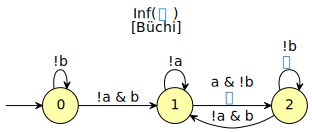

In [6]:
f = spot.formula("G!(a&b) & (F b) & G( (b) -> (F a) )")
display(f)
a = spot.translate(f, "Buchi")
a

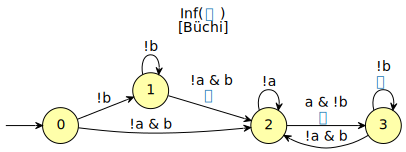

In [10]:
rabinizer_dir = '/home/crarojasca/Storage/Monash/HRL_LTL_Goals/almanac/src/rabinizer4'
def get_aut(ltl):
    aut = subprocess.check_output(
        "bin/ltl2ldba \"{}\"".format(ltl), 
        cwd=rabinizer_dir, shell=True)
    a = spot.automaton(aut.decode('utf-8'))
    return a

ltl = "G!(a&b) & (F b) & G( (b) -> (F a) )"
a = get_aut(ltl)
a

 B => A

spot.formula("Fb & G!(a & b) & G(b -> Fa) & G(a -> X!alive)")

spot.formula("alive & F(alive & b) & G(!alive | !(a & b)) & G(!alive | (b -> F(a & alive))) & G(!alive | (a -> X!alive)) & (alive U G!alive)")

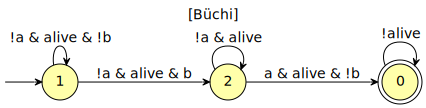

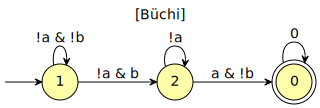

In [11]:
f = spot.formula("G!(a&b) & (F b) & G( (b) -> (F a) ) & G( a -> X !alive)")
display(f)
f = spot.from_ltlf("G!(a&b) & (F b) & G( (b) -> (F a) ) & G( a -> X !alive)")
display(f)
aut = f.translate('small', 'buchi', 'sbacc')
display(aut)
aut = spot.to_finite(aut)
aut

## Automaton Structure

In [53]:
bdict = aut.get_dict()
init = aut.get_init_state_number()
ui = aut.is_univ_dest(init)
print("Initial states: {}{}{}".format("{ " if ui else "",
                                      " ".join(map(str, aut.univ_dests(init))),
                                      " }" if ui else ""))
for s in range(0, aut.num_states()):
    print("State {}:".format(s))
    for t in aut.out(s):
        ud = aut.is_univ_dest(t)
        print("  edge({} -> {}{}{})".format(t.src,
                                            "{ " if ud else "",
                                            " ".join(map(str, aut.univ_dests(t))),
                                            " }" if ud else ""))
        print("    label =", spot.bdd_format_formula(bdict, t.cond))
        print("    acc sets =", t.acc)

Initial states: 1
State 0:
  edge(0 -> 0)
    label = 0
    acc sets = {0}
State 1:
  edge(1 -> 1)
    label = !a & !b & !c
    acc sets = {}
  edge(1 -> 2)
    label = a & !b & !c
    acc sets = {}
State 2:
  edge(2 -> 2)
    label = !b & !c
    acc sets = {}
  edge(2 -> 3)
    label = !a & b & !c
    acc sets = {}
State 3:
  edge(3 -> 0)
    label = !a & !b & c
    acc sets = {}
  edge(3 -> 3)
    label = !a & !c
    acc sets = {}


In [41]:
TOKENS = [ ['r1', 'red', 0, 0],  ['r2', 'red', 1, 1], ['r3', 'red', 6, 3],   
    ['g1', 'green', 4, 0], ['g2', 'green', 5, 2], ['g3', 'green', 5, 4],
    ['b1', 'blue', 1, 3], ['b2', 'blue', 2, 4],  ['b3', 'blue', 6, 0], 
    ['p1', 'pink', 2, 1], ['p2', 'pink', 2, 3], ['p3', 'pink', 4, 2], 
    ['n1', 'brown', 3, 0], ['n2', 'brown', 3, 4], ['n3', 'brown', 6, 1],
    ['y1', 'gray', 0, 2], ['y2', 'gray', 3, 1], ['y3', 'gray', 4, 3],
    ['u1', 'purple', 0, 4], ['u2', 'purple', 1, 0], ['u3', 'purple', 5, 1]
]

In [43]:
for token in TOKENS:
    print(token)

['r1', 'red', 0, 0]
['r2', 'red', 1, 1]
['r3', 'red', 6, 3]
['g1', 'green', 4, 0]
['g2', 'green', 5, 2]
['g3', 'green', 5, 4]
['b1', 'blue', 1, 3]
['b2', 'blue', 2, 4]
['b3', 'blue', 6, 0]
['p1', 'pink', 2, 1]
['p2', 'pink', 2, 3]
['p3', 'pink', 4, 2]
['n1', 'brown', 3, 0]
['n2', 'brown', 3, 4]
['n3', 'brown', 6, 1]
['y1', 'gray', 0, 2]
['y2', 'gray', 3, 1]
['y3', 'gray', 4, 3]
['u1', 'purple', 0, 4]
['u2', 'purple', 1, 0]
['u3', 'purple', 5, 1]


spot.formula("G!((a & b & c) | (a & b) | (b & c) | (a & c)) & Fa & Fb & Fc")

spot.formula("alive & F(alive & b) & F(alive & c) & F(a & alive) & (alive U G!alive) & G(!alive | !((a & b & c) | (a & b) | (b & c) | (a & c)))")

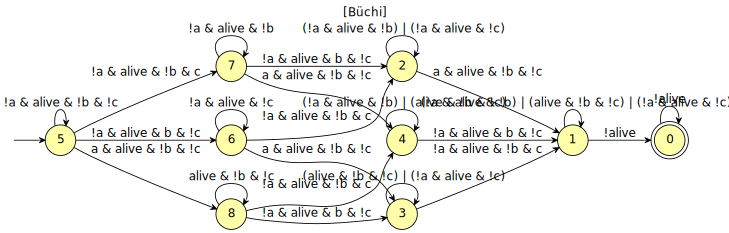

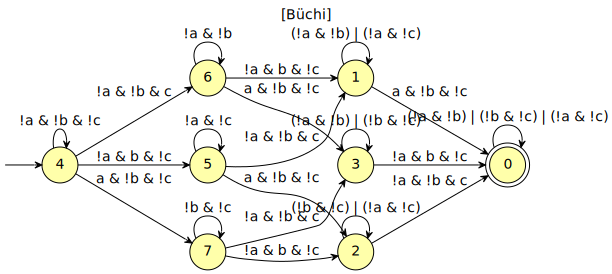

In [122]:
formula = "G!(a&b&c | a&b | b&c | c&a) & ((F a) & (F b) & (F c))"
f = spot.formula(formula)
display(f)
f = spot.from_ltlf(formula)
display(f)
aut = f.translate('small', 'buchi', 'sbacc')
display(aut)
aut = spot.to_finite(aut)
aut

In [100]:
formula = list(aut.out(4))[0].cond

In [126]:
list(aut.out(4))[0].cond

<buddy.bdd; proxy of <Swig Object of type 'bdd *' at 0x7f7c641f4420> >

In [ ]:
spot.bdd_to_formula

In [77]:
import buddy

In [127]:
!True

/usr/bin/sh: 1: True: not found


In [92]:
gr = aut.get_graph() #graph
init_state = aut.get_init_state_number() #init state
init_state

4

In [107]:
vars_ = {'a':0, 'b':0, 'c':1}

In [109]:
spot.bdd_format_formula(aut.get_dict(), formula)

'!a & !b & !c'

In [114]:
aut.ap_vars()

<buddy.bdd; proxy of <Swig Object of type 'bdd *' at 0x7f7c641f9db0> >

In [118]:
aut.succ_iter(aut.get_dict())

TypeError: in method 'twa_succ_iter', argument 2 of type 'spot::state const *'

In [ ]:
aut

In [125]:
aut.register_ap("b")

0

In [84]:
a = buddy.bdd_ithvar(0);
b = buddy.bdd_ithvar(1);
c = buddy.bdd_ithvar(1);
z = buddy.bdd_apply(a,b,formula)
z

TypeError: in method 'bdd_apply', argument 3 of type 'int'

In [83]:
buddy.bdd_apply?

In [87]:
spot.bdd_format_isop

In [64]:
bdict = aut.get_dict()
init = aut.get_init_state_number()
ui = aut.is_univ_dest(init)
print("Initial states: {}".format(init))

for s in range(0, aut.num_states()):
    print("State {}:".format(s))
    for t in aut.out(s):
        print("  edge({} -> {})".format(t.src, t.dst))
        print("    label =", spot.bdd_format_formula(bdict, t.cond))
        print("    acc sets =", t.acc)

Initial states: 4
State 0:
  edge(0 -> 0)
    label = (!a & !b) | (!b & !c) | (!a & !c)
    acc sets = {0}
State 1:
  edge(1 -> 0)
    label = !a & b & !c
    acc sets = {}
  edge(1 -> 1)
    label = (!a & !b) | (!b & !c)
    acc sets = {}
State 2:
  edge(2 -> 0)
    label = a & !b & !c
    acc sets = {}
  edge(2 -> 2)
    label = (!a & !b) | (!a & !c)
    acc sets = {}
State 3:
  edge(3 -> 0)
    label = !a & !b & c
    acc sets = {}
  edge(3 -> 3)
    label = (!b & !c) | (!a & !c)
    acc sets = {}
State 4:
  edge(4 -> 4)
    label = !a & !b & !c
    acc sets = {}
  edge(4 -> 5)
    label = !a & b & !c
    acc sets = {}
  edge(4 -> 6)
    label = !a & !b & c
    acc sets = {}
  edge(4 -> 7)
    label = a & !b & !c
    acc sets = {}
State 5:
  edge(5 -> 2)
    label = !a & !b & c
    acc sets = {}
  edge(5 -> 3)
    label = a & !b & !c
    acc sets = {}
  edge(5 -> 5)
    label = !a & !c
    acc sets = {}
State 6:
  edge(6 -> 1)
    label = a & !b & !c
    acc sets = {}
  edge(6 -> 2)

In [62]:
bdict = aut.get_dict()
init = aut.get_init_state_number()
ui = aut.is_univ_dest(init)
print("Initial states: {}{}{}".format("{ " if ui else "",
                                      " ".join(map(str, aut.univ_dests(init))),
                                      " }" if ui else ""))
for s in range(0, aut.num_states()):
    print("State {}:".format(s))
    for t in aut.out(s):
        ud = aut.is_univ_dest(t)
        print("  edge({} -> {}{}{})".format(t.src,
                                            "{ " if ud else "",
                                            " ".join(map(str, aut.univ_dests(t))),
                                            " }" if ud else ""))
        print("    label =", spot.bdd_format_formula(bdict, t.cond))
        print("    acc sets =", t.acc)

Initial states: 4
State 0:
  edge(0 -> 0)
    label = (!a & !b) | (!b & !c) | (!a & !c)
    acc sets = {0}
State 1:
  edge(1 -> 0)
    label = !a & b & !c
    acc sets = {}
  edge(1 -> 1)
    label = (!a & !b) | (!b & !c)
    acc sets = {}
State 2:
  edge(2 -> 0)
    label = a & !b & !c
    acc sets = {}
  edge(2 -> 2)
    label = (!a & !b) | (!a & !c)
    acc sets = {}
State 3:
  edge(3 -> 0)
    label = !a & !b & c
    acc sets = {}
  edge(3 -> 3)
    label = (!b & !c) | (!a & !c)
    acc sets = {}
State 4:
  edge(4 -> 4)
    label = !a & !b & !c
    acc sets = {}
  edge(4 -> 5)
    label = !a & b & !c
    acc sets = {}
  edge(4 -> 6)
    label = !a & !b & c
    acc sets = {}
  edge(4 -> 7)
    label = a & !b & !c
    acc sets = {}
State 5:
  edge(5 -> 2)
    label = !a & !b & c
    acc sets = {}
  edge(5 -> 3)
    label = a & !b & !c
    acc sets = {}
  edge(5 -> 5)
    label = !a & !c
    acc sets = {}
State 6:
  edge(6 -> 1)
    label = a & !b & !c
    acc sets = {}
  edge(6 -> 2)

spot.formula("alive & (alive U G!alive) & G(!alive | !(a & b)) & G(!alive | (a -> X(!alive | b)))")

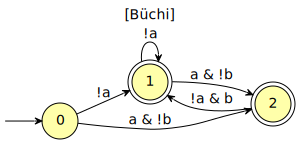

In [15]:
# Remove "alive" atomic propositions and print result.
f = spot.from_ltlf("G!(a&b) & G(a -> X b) & G(a -> X b)")
display(f)
aut = f.translate('small', 'buchi', 'sbacc')
spot.to_finite(aut)

C => B => A

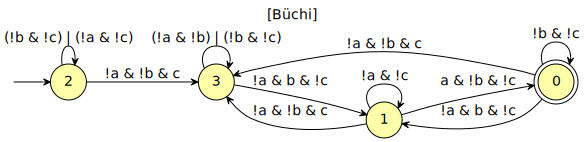

In [16]:
# Remove "alive" atomic propositions and print result.
f = spot.from_ltlf("G!(c&b&a | c&b | c&a | a&b) & (F c) & G( (c) -> (F b) ) & G( (b) -> (F a) )")
aut = f.translate('small', 'buchi', 'sbacc')
spot.to_finite(aut)

spot.formula("G!((a & b & c) | (a & b) | (a & c) | (b & c)) & Fb & ((Fb -> Fa) -> Fc)")

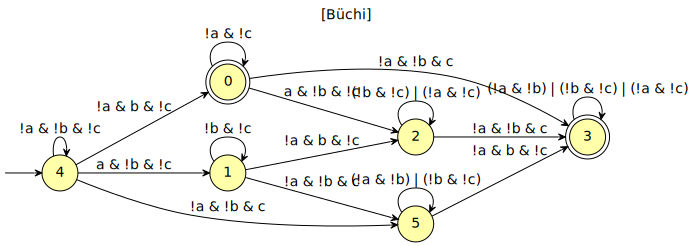

In [17]:
f = spot.formula("G!(a&b&c | a&b | a&c | b&c) & F(b) & (( (F b) -> (F(a)) ) -> (F c))")
display(f)
a = spot.translate(f)
a

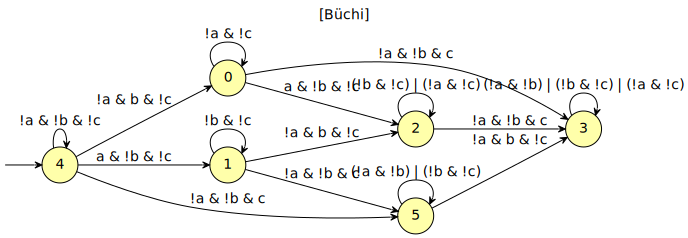

In [19]:
aut = f.translate('small', 'buchi', 'sbacc')
spot.to_finite(aut)

In [20]:
# Remove "alive" atomic propositions and print result.
print(spot.to_finite(aut).to_str('hoa'))

HOA: v1
States: 6
Start: 4
AP: 3 "b" "a" "c"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels state-acc deterministic
--BODY--
State: 0
[!1&!2] 0
[!0&1&!2] 2
[!0&!1&2] 3
State: 1
[!0&!2] 1
[0&!1&!2] 2
[!0&!1&2] 5
State: 2
[!0&!2 | !1&!2] 2
[!0&!1&2] 3
State: 3
[!0&!1 | !0&!2 | !1&!2] 3
State: 4
[0&!1&!2] 0
[!0&1&!2] 1
[!0&!1&!2] 4
[!0&!1&2] 5
State: 5
[0&!1&!2] 3
[!0&!1 | !0&!2] 5
--END--


In [21]:
bdict = a.get_dict()
init = a.get_init_state_number()
ui = a.is_univ_dest(init)
print("Initial states: {}{}{}".format("{ " if ui else "",
                                      " ".join(map(str, a.univ_dests(init))),
                                      " }" if ui else ""))
for s in range(0, a.num_states()):
    print("State {}:".format(s))
    for t in a.out(s):
        ud = a.is_univ_dest(t)
        print("  edge({} -> {}{}{})".format(t.src,
                                            "{ " if ud else "",
                                            " ".join(map(str, a.univ_dests(t))),
                                            " }" if ud else ""))
        print("    label =", spot.bdd_format_formula(bdict, t.cond))
        print("    acc sets =", t.acc)

Initial states: 4
State 0:
  edge(0 -> 0)
    label = !a & !c
    acc sets = {0}
  edge(0 -> 2)
    label = a & !b & !c
    acc sets = {0}
  edge(0 -> 3)
    label = !a & !b & c
    acc sets = {0}
State 1:
  edge(1 -> 1)
    label = !b & !c
    acc sets = {}
  edge(1 -> 2)
    label = !a & b & !c
    acc sets = {}
  edge(1 -> 5)
    label = !a & !b & c
    acc sets = {}
State 2:
  edge(2 -> 2)
    label = (!b & !c) | (!a & !c)
    acc sets = {}
  edge(2 -> 3)
    label = !a & !b & c
    acc sets = {}
State 3:
  edge(3 -> 3)
    label = (!a & !b) | (!b & !c) | (!a & !c)
    acc sets = {0}
State 4:
  edge(4 -> 0)
    label = !a & b & !c
    acc sets = {}
  edge(4 -> 1)
    label = a & !b & !c
    acc sets = {}
  edge(4 -> 4)
    label = !a & !b & !c
    acc sets = {}
  edge(4 -> 5)
    label = !a & !b & c
    acc sets = {}
State 5:
  edge(5 -> 3)
    label = !a & b & !c
    acc sets = {}
  edge(5 -> 5)
    label = (!a & !b) | (!b & !c)
    acc sets = {}


In [22]:
a.get_dict()

<spot.impl.bdd_dict; proxy of <Swig Object of type 'std::shared_ptr< spot::bdd_dict > *' at 0x7f7c651b9ae0> >

In [23]:
a = spot.translate(f, 'Buchi', 'state-based', 'complete')